# Import libraries

In [1]:
# Data handling
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split 
from torchvision import transforms
import cv2

# Torch
import torch
from torch import nn, optim
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50 # model resnet

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from torchmetrics.classification import MulticlassAccuracy

# os
import os

# Path
from pathlib import Path

# tqdm
from tqdm.auto import tqdm

# random
import random

# typing
from typing import Dict,List

# Warnings
import warnings
warnings.filterwarnings("ignore")

/Users/rushabhkakadiya/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# Classes we have in our data set.
total_classes = os.listdir("data/uncropped")
total_classes

['pituitary', '.DS_Store', 'notumor', 'glioma', 'meningioma']

In [3]:
total_classes.remove('.DS_Store')

In [4]:
# Total number of images per class.
images_path = Path("data/uncropped")
for c in total_classes:
    print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* pituitary = 300 images
* notumor = 405 images
* glioma = 300 images
* meningioma = 306 images


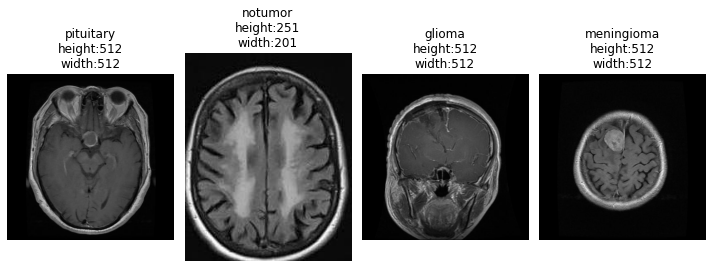

In [5]:
# Let's display 1 image per class.
fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
    img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
    img_selected = random.choice(img_total_class)
    img_BGR = cv2.imread(str(img_selected))
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    height,width,channel = img_RGB.shape
    ax[i].imshow(img_RGB)
    ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
    ax[i].axis("off")

fig.tight_layout()
fig.show()

In [6]:
# Routes where the images are located.
images_path_list = list(images_path.glob("*/*.jpg"))
total_images = len(images_path_list)

# We store the heights of the images.
seq_height = [None]*total_images
# We store the width of the images.
seq_width = [None]*total_images

for i,img_path in enumerate(images_path_list):
    img = Image.open(img_path)
    seq_height[i] = img.height
    seq_width[i] = img.width
print("Total number of Images in Dataset : {}".format(total_images))

Total number of Images in Dataset : 1311


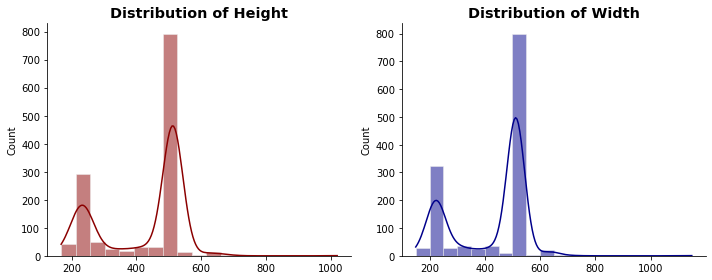

In [7]:
# Let's visualize the distribution of the length and width of the images.
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
plt.style.use("ggplot")
ax = ax.flat

sns.histplot(seq_height, 
             kde = True, 
             color = "darkred",
             ax = ax[0])
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_title("Distribution of Height", fontweight = "bold", color = "black")
sns.histplot(seq_width, 
             kde = True, 
             color = "darkblue",
             ax = ax[1])
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_title("Distribution of Width", fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

In [8]:
# Create Directory for cropped Data
if not os.path.isdir("data/cropped/"):
        os.mkdir("data/cropped/")
path = "data/cropped/"
for i in total_classes:
    if not os.path.isdir("data/cropped/" + i):
        os.mkdir("data/cropped/" + i)

In [9]:
import imutils   
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


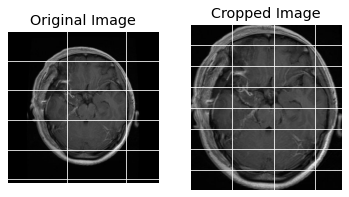

In [10]:
# Check the crop
example_img = cv2.imread("/Users/rushabhkakadiya/Documents/McMaster /DL/FPROJECT/data/uncropped/glioma/Te-gl_0289.jpg")
cropped_image_example = crop_image(example_img, plot=True)

In [11]:
# Crop the Images and Save to respective directories
directory = "/Users/rushabhkakadiya/Documents/McMaster /DL/FPROJECT/data/uncropped/"

for x in total_classes:
    path_c = directory + x
    j = 0
    for i in tqdm(os.listdir(path_c)):
        path = os.path.join(path_c, i)
        img = cv2.imread(path)
        img = crop_image(img, plot=False)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            save_path = "/Users/rushabhkakadiya/Documents/McMaster /DL/FPROJECT/data/cropped/"+ x +"/"+ str(i) + ".jpg"
            cv2.imwrite(save_path, img)
            j = j+1

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/405 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/306 [00:00<?, ?it/s]

In [12]:
# We create a pd.DataFrame where we will store the paths of the images and their class 
# and then iterate and create our set of images and labels.
images_path = Path("data/cropped")
images_path_list = list(images_path.glob("*/*.jpg"))
img_path_and_class = {"img_path":[], 
                      "classes":[]}
for i in images_path_list:
    img_path_and_class["img_path"].append(i)
    img_path_and_class["classes"].append(i.parent.stem)

df_img_path_and_class = pd.DataFrame(img_path_and_class)
df_img_path_and_class.head()

,img_path,classes
0,data/cropped/pituitary/Te-pi_0107.jpg.jpg,pituitary
1,data/cropped/pituitary/Te-pi_0117.jpg.jpg,pituitary
2,data/cropped/pituitary/Te-pi_0261.jpg.jpg,pituitary
3,data/cropped/pituitary/Te-pi_0271.jpg.jpg,pituitary
4,data/cropped/pituitary/Te-pi_0203.jpg.jpg,pituitary


In [13]:
# Now let's separate our pd.DataFrame into path's and classes.
X = df_img_path_and_class.drop("classes", axis = 1)
y = df_img_path_and_class["classes"]

In [14]:
# We divide into training and testing.
# We define the random seed for reproducibility.
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, 
                                       y, 
                                       test_size = 0.2, 
                                       random_state = SEED, 
                                       stratify = y)

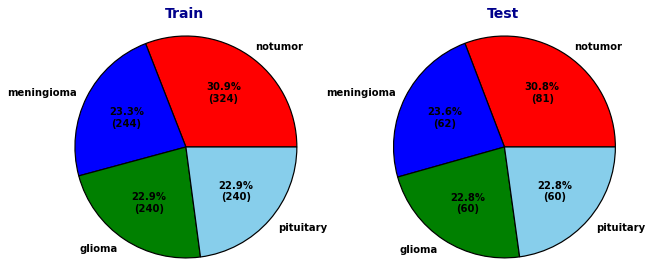

In [15]:
# We visualize how many images we have per class in both the training and test set.
# Visualization of the objective variable in the training and test set.
df_pct_train = y_train.value_counts().to_frame()
df_pct_train = df_pct_train.rename(columns = {'y':'count'})
labels_train = df_pct_train.index.to_list()
values_train = df_pct_train.iloc[:,0]

df_pct_test = y_test.value_counts().to_frame()
df_pct_test = df_pct_test.rename(columns = {'y':'count'})
labels_test = df_pct_test.index.to_list()
values_test = df_pct_test.iloc[:,0]

fig,axes = plt.subplots(1,2,figsize = (9,4))

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"


axes[0].pie(x = values_train, labels = labels_train, autopct = autopct_fun(values_train),
            wedgeprops = {'linewidth':1.2, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'}, 
            colors = ["r","b","g","skyblue"])
axes[0].set_title('Train', fontsize = 14, fontweight = 'bold', color = 'darkblue')
axes[0].axis("equal")

axes[1].pie(x = values_test, labels = labels_test, autopct = autopct_fun(values_test),
            wedgeprops = {'linewidth':1.2, 'edgecolor':'black'},
            textprops = {'fontsize':10, 'fontweight':'bold'}, 
            colors = ["r","b","g","skyblue"])
axes[1].set_title('Test', fontsize = 14, fontweight = 'bold', color = 'darkblue')
axes[1].axis("equal")

fig.tight_layout()
fig.subplots_adjust(top = 0.9)
fig.show()

In [16]:
# We map the labels (y_train and y_test) to convert them into indexes:
# 0: glioma
# 1: notumor
# 2: meningioma
# 3: pituitary

label_map = {"glioma":0, 
             "notumor":1, 
             "meningioma":2, 
             "pituitary":3}

y_train_array = np.array(y_train.map(label_map))
y_train_torch = torch.from_numpy(y_train_array)

y_test_array = np.array(y_test.map(label_map))
y_test_torch = torch.from_numpy(y_test_array)

In [17]:
# We define the transformations that are applied to the training and testing data.
train_transforms = transforms.Compose([
    transforms.Resize((128,128)), 
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()])

test_transforms = transforms.Compose([
    transforms.Resize((128,128)), 
    transforms.ToTensor()])

In [18]:
# We iterate over our pd.DataFrame that we created to transform our images
# for both the training and test set.
total_images_train = len(X_train)
images_train = [None] * total_images_train

for i,(_,image_path_train) in enumerate(X_train.iterrows()):
    img_train = Image.open(Path(image_path_train[0])).convert('RGB')
    images_train[i] = train_transforms(img_train)


total_images_test = len(X_test)
images_test = [None] * total_images_test

for i,(_,image_path_test) in enumerate(X_test.iterrows()):
    img_test = Image.open(Path(image_path_test[0])).convert('RGB')
    images_test[i] = test_transforms(img_test)

In [19]:
# We convert the list into a tensor.
X_train_torch = torch.stack(images_train)
X_test_torch = torch.stack(images_test)

In [20]:
# Convert to Datasets format.
class CustomDataset(Dataset):
    def __init__(self, images,labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = self.images[idx]
        y = self.labels[idx]
        return x,y

In [21]:
train_dataset = CustomDataset(X_train_torch, y_train_torch)
test_dataset = CustomDataset(X_test_torch, y_test_torch)

In [22]:
# Convert to DataLoader's.
BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True)

test_dataloader = DataLoader(test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False)

In [23]:
# We visualize a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16]))

In [24]:
# # We define our model.
model_resnet = resnet50()

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [26]:
summary(model = model_resnet, 
        input_size = [16,3,128,128], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 20, 
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 128, 128]    [16, 1000]           --                   True
├─Conv2d (conv1)                         [16, 3, 128, 128]    [16, 64, 64, 64]     9,408                True
├─BatchNorm2d (bn1)                      [16, 64, 64, 64]     [16, 64, 64, 64]     128                  True
├─ReLU (relu)                            [16, 64, 64, 64]     [16, 64, 64, 64]     --                   --
├─MaxPool2d (maxpool)                    [16, 64, 64, 64]     [16, 64, 32, 32]     --                   --
├─Sequential (layer1)                    [16, 64, 32, 32]     [16, 256, 32, 32]    --                   True
│    └─Bottleneck (0)                    [16, 64, 32, 32]     [16, 256, 32, 32]    --                   True
│    │    └─Conv2d (conv1)               [16, 64, 32, 32]     [16, 64, 32, 32]     4,096                True
│    │    └─BatchN

In [27]:
# Let's visualize the last layer which we will modify.
model_resnet.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [28]:
# Now we modify the last layer.
output_shape = len(total_classes) # total_classes = 4

model_resnet.fc = nn.Sequential(nn.Linear(in_features = 2048, 
                                          out_features = output_shape, 
                                          bias = True))

In [29]:
# We visualize the structure of the model again with the modification made.
summary(model = model_resnet, 
        input_size = [16,3,128,128], 
        col_names = ["input_size","output_size","num_params","trainable"], 
        col_width = 20, 
        row_settings = ["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 128, 128]    [16, 4]              --                   True
├─Conv2d (conv1)                         [16, 3, 128, 128]    [16, 64, 64, 64]     9,408                True
├─BatchNorm2d (bn1)                      [16, 64, 64, 64]     [16, 64, 64, 64]     128                  True
├─ReLU (relu)                            [16, 64, 64, 64]     [16, 64, 64, 64]     --                   --
├─MaxPool2d (maxpool)                    [16, 64, 64, 64]     [16, 64, 32, 32]     --                   --
├─Sequential (layer1)                    [16, 64, 32, 32]     [16, 256, 32, 32]    --                   True
│    └─Bottleneck (0)                    [16, 64, 32, 32]     [16, 256, 32, 32]    --                   True
│    │    └─Conv2d (conv1)               [16, 64, 32, 32]     [16, 64, 32, 32]     4,096                True
│    │    └─BatchN

In [30]:
# Let's visualize one step forward.
model_resnet(batch_images.to(device))

tensor([[-0.2647, -0.4722, -0.7356, -0.8063],
        [-0.2882, -0.2840, -0.5334, -0.6504],
        [-0.3478, -0.1442, -0.6931, -1.4583],
        [-0.1899, -0.1067, -0.4892, -0.9266],
        [-0.0910, -0.2760, -0.6922, -0.4839],
        [-0.3533, -0.3952, -0.7965, -0.5170],
        [-0.3407, -0.3446, -0.5648, -0.6003],
        [-0.4381, -0.4442, -0.7833, -0.5839],
        [ 0.0589,  1.0912, -2.4557, -2.5704],
        [-0.3440, -0.4456, -0.7071, -0.3185],
        [-0.2664, -0.1755, -0.5785, -0.7255],
        [-0.0886, -0.0985, -0.8095, -0.7208],
        [-0.1846, -0.2963, -0.7205, -0.9153],
        [-0.4004, -0.1133, -0.5760, -0.8170],
        [-0.2831,  0.1372, -0.6924, -1.0222],
        [-0.2873, -0.4722, -0.6085, -0.5445]], grad_fn=<AddmmBackward0>)

In [31]:
# We define our loss function and optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr = 0.01)

# We create our functions to execute the training.

In [32]:
def train_step(model:torch.nn.Module, 
               loss_fn:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               optimizer:torch.optim.Optimizer):
    model.train()

    train_loss = 0.
    accuracy_train = MulticlassAccuracy(num_classes = 4, average = 'micro').to(device)
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logits = model(X)

        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_probs = torch.softmax(y_pred_logits, dim = 1)
        accuracy_train.update(y_pred_probs, y)
    
    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader)

    return train_loss, train_accuracy

In [33]:
def test_step(model:torch.nn.Module, 
              loss_fn:torch.nn.Module, 
              dataloader:torch.utils.data.DataLoader):
  
    model.eval()

    test_loss = 0.
    accuracy_test = MulticlassAccuracy(num_classes = 4, average = 'micro').to(device)
    
    with torch.inference_mode():

        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
            test_loss += loss.item()

            y_pred_probs = torch.softmax(y_pred_logits, dim = 1)
            accuracy_test.update(y_pred_probs, y)

    test_accuracy = accuracy_test.compute()
    test_loss = test_loss/len(dataloader)

    return test_loss, test_accuracy

In [34]:
# We create our checkpoint to store our best model, the period where the lowest loss and the optimizer were obtained.
def save_checkpoint(filename, model, epoch, optimizer, loss):
    state = {"filename":filename, 
           "state_dict":model.state_dict(), 
           "epoch":epoch, 
           "optimizer":optimizer.state_dict(), 
           "loss":loss}

    torch.save(state, filename)

In [35]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          test_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int=10):
  
    results = {"train_loss":[], 
             "test_loss":[], 
             "train_accuracy":[], 
             "test_accuracy":[]}
    
    best_test_loss = float("inf")

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                            loss_fn = loss_fn, 
                                            dataloader = train_dataloader, 
                                            optimizer = optimizer)
    
        test_loss, test_accuracy = test_step(model = model, 
                                         loss_fn = loss_fn, 
                                         dataloader = test_dataloader)
        
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            file_name = "best_model.pt"
            save_checkpoint(file_name, model, epoch, optimizer, best_test_loss)

        print(f"Epoch: {epoch+1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"Test Loss: {test_loss:.4f} | ", 
              f"Test Accuracy: {test_accuracy:.4f}")
        
    
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_accuracy"].append(test_accuracy)
            
    return results

In [ ]:
#We execute the training.
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

EPOCHS = 100
MODEL_RESULTS = train(model_resnet.to(device), train_dataloader, 
                      test_dataloader, loss_fn, optimizer, EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 2.5715 |  Train Accuracy: 0.3607 |  Test Loss: 6.0833 |  Test Accuracy: 0.3726
Epoch: 2 |  Train Loss: 1.3459 |  Train Accuracy: 0.4017 |  Test Loss: 1.2098 |  Test Accuracy: 0.3954
Epoch: 3 |  Train Loss: 1.3583 |  Train Accuracy: 0.4065 |  Test Loss: 1.2182 |  Test Accuracy: 0.4411
Epoch: 4 |  Train Loss: 1.1886 |  Train Accuracy: 0.4275 |  Test Loss: 1.2778 |  Test Accuracy: 0.4411
Epoch: 5 |  Train Loss: 1.1282 |  Train Accuracy: 0.4618 |  Test Loss: 1.2601 |  Test Accuracy: 0.3992
Epoch: 6 |  Train Loss: 1.1151 |  Train Accuracy: 0.4475 |  Test Loss: 1.1289 |  Test Accuracy: 0.4829
Epoch: 7 |  Train Loss: 1.0415 |  Train Accuracy: 0.5324 |  Test Loss: 1.5455 |  Test Accuracy: 0.4791
Epoch: 8 |  Train Loss: 1.0762 |  Train Accuracy: 0.5162 |  Test Loss: 1.0241 |  Test Accuracy: 0.5171
Epoch: 9 |  Train Loss: 1.0326 |  Train Accuracy: 0.5439 |  Test Loss: 1.0842 |  Test Accuracy: 0.5247
Epoch: 10 |  Train Loss: 0.9871 |  Train Accuracy: 0.5744 |  Test Loss: 1

In [ ]:
print(MODEL_RESULTS)

In [ ]:
# Function to plot the loss and metric during each training epoch.
def plot_loss_metric_curve(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    test_loss = model_results["test_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    test_accuracy = [float(value) for value in model_results["test_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    plt.style.use("ggplot")
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(test_loss, color = "blue", label = "Test")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(test_accuracy, color = "blue", label = "Test")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()


In [ ]:
plot_loss_metric_curve(MODEL_RESULTS)

In [ ]:
# We load the best model.
path_checkpoint = "best_model.pt"
checkpoint = torch.load(path_checkpoint)

In [ ]:
# We visualize the time when we obtained the least loss.
epoch = checkpoint["epoch"] + 1
loss = checkpoint["loss"]
print(f"Epoch: {epoch}")
print(f"Loss: {loss}")

In [ ]:
model_resnet.load_state_dict(checkpoint["state_dict"])

model_resnet.eval()

with torch.inference_mode():
    y_pred_train_logits = model_resnet(X_train_torch.to(device))
    y_pred_test_logits = model_resnet(X_test_torch.to(device))

In [ ]:
# Predictions Training
y_pred_train_probs = torch.softmax(y_pred_train_logits, dim = 1)
y_pred_train_class = torch.argmax(y_pred_train_probs, dim = 1)
y_pred_train = y_pred_train_class.cpu().numpy()

# Predictions Test
y_pred_test_probs = torch.softmax(y_pred_test_logits, dim = 1)
y_pred_test_class = torch.argmax(y_pred_test_probs, dim = 1)
y_pred_test = y_pred_test_class.cpu().numpy()

In [ ]:
# We create the confusion matrix for the training and test set.
cf_mx_train = confusion_matrix(y_train_array, y_pred_train)
cf_mx_test = confusion_matrix(y_test_array, y_pred_test)

In [ ]:
# Confusion Matrix Plot
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4.2))
ax = ax.flat
sns.heatmap(cf_mx_train, 
            cmap = 'Blues', 
            annot = True, 
            fmt = ' ', 
            annot_kws = {"fontsize":10, 
                         "fontweight":"bold"}, 
            linewidths = 1, 
            linecolor = "white", 
            cbar = False, 
            square = True, 
            xticklabels = label_map,
            yticklabels = label_map,
            ax = ax[0])
ax[0].set_title('Confusion Matrix Train', fontsize = 12, fontweight = 'bold', color = 'black')

sns.heatmap(cf_mx_test, 
            cmap = 'Reds', 
            annot = True, 
            fmt = ' ', 
            annot_kws = {"fontsize":10, 
                         "fontweight":"bold"}, 
            linewidths = 1, 
            linecolor = "white", 
            cbar = False, 
            square = True, 
            xticklabels = label_map, 
            yticklabels = label_map,
            ax = ax[1])
ax[1].set_title('Confusion Matrix Test', fontsize = 12, fontweight = 'bold', color = 'black')

fig.tight_layout()
fig.show()

In [ ]:
# We create a dictionary to do a reverse mapping to the labels for both the training and test set.
id2label = {0: 'glioma', 1: 'notumor', 2: 'meningioma', 3: 'pituitary'}

In [ ]:
# We convert the original labels and predictions from number to string by applying a mapping.
y_pred_train_np = np.array(pd.Series(y_pred_train).map(id2label))

y_train_np = np.array(y_train)

y_pred_test_np = np.array(pd.Series(y_pred_test).map(id2label))

y_test_np = np.array(y_test)

In [ ]:
print("=="*30)
print(" " * 13, "Classification Report Train")
print("=="*30)
print(classification_report(y_train_np, y_pred_train_np))

print("=="*30)
print(" " * 13, "Classification Report Test")
print("=="*30)
print(classification_report(y_test_np, y_pred_test_np))